In [37]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import tqdm

In [38]:
# Constants
colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 255),
    (255, 192, 203),
    (0, 125, 125),
    (255, 125, 125),
    (125, 255, 255),
    (255, 255, 125),
    (125, 255, 125),
    (255, 125, 255),
    (125, 125, 125),
    (125, 125, 0),
    (0, 125, 0)
    
]

4.1.1 

(3) In the given sequence (00-29) pick 15 cells. These cells are traced cells over the
sequence of the 30 images. Indicate your choices with a label/number in the initial
image. These labels are the result from a segmentation operation that successfully
find all the relevant, i.e. 15, cells in the image(s). Develop, apply, explain and motivate
your segmentation procedure.

In [39]:
# Read all 30 images from the controll experiment
images_ctrl = [np.mean(plt.imread(f"images/MTLn3-Ctrl00{'0' + str(i) if i < 10 else i}.tif"), -1).astype(np.uint16) for i in range(30)]

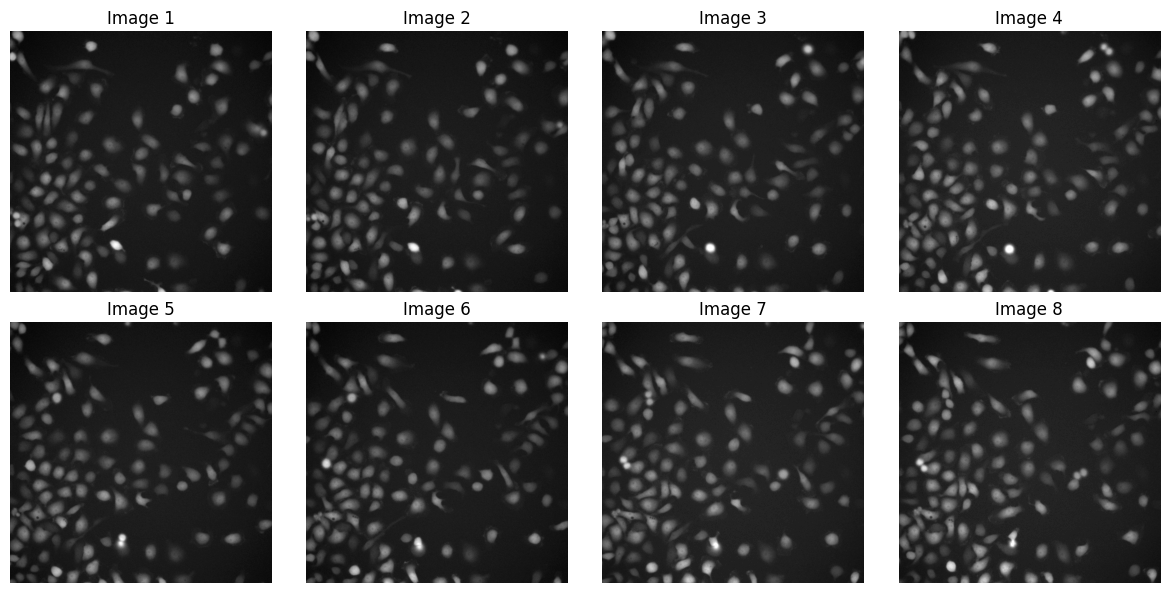

In [40]:
def display_eight(images, start=0):
    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Iterate over the image paths and corresponding axes
    for i, (image, ax) in enumerate(zip(images, axes.flat)):
        # Load and display the image on the current axis
        ax.imshow(image, cmap="gray")
        ax.axis('off')
        ax.set_title(f'Image {start+i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the figure
    plt.show()
    
display_eight(images_ctrl[:8])

In [50]:
def plot_segmentation(original, contours, number=1, show=True):
        color_image = np.stack([original.copy()]*3, axis=-1).astype(np.uint16)
        original_image = copy.deepcopy(original)

        for i, (contour, color) in enumerate(zip(contours, colors)):
            cv2.drawContours(color_image, [contour], -1, color=color, thickness=cv2.FILLED)
            cx, cy = min(contour, key=lambda l: l[0][0])[0][0], min(contour, key=lambda l: l[0][1])[0][1]

            cv2.putText(color_image, text= str(i+1), org=(cx,cy), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), 
                        thickness=2, lineType=cv2.LINE_AA)
            cv2.putText(original_image, text= str(i+1), org=(cx,cy), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), 
                        thickness=2, lineType=cv2.LINE_AA)
        
        if show:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(color_image)
            axes[1].imshow(original_image, cmap="gray")
            axes[0].set_title(f"Selected cells in segmented image {number}")
            axes[1].set_title(f"Selected cells in original image {number}")
            plt.show()
        
        return color_image, original_image


def segment_cells(image, plot=False):
    """
    Segment different cells in image. Note that many pipelines were tried, and just normalizing and thresholding worked best
    """
    original = image.copy()
    # Normalize
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)    
    
    # Open the image to remove small shapes
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (9,9)))
    
    # Threshold the image
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Convert to unsigned 8-bit integers
    image = image.astype(np.uint8)

    # Find the contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contours
    largest = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    
    # Plot the segmented and labeled images
    if plot:
        plot_segmentation(original, largest)

    return contours

segment_cells(images_ctrl[0], plot=False)
pass

In [53]:
class Cell:
    def __init__(self, contour, idx):
        self.idx = idx
        self.contour = contour
        self.mean_x = np.mean(contour[:, :, 0])
        self.mean_y = np.mean(contour[:, :, 1])
        self.area = cv2.contourArea(contour)
        self.width = max(contour[:, :, 0]) - min(contour[:, :, 0])
        self.height = max(contour[:, :, 1]) - min(contour[:, :, 1])
        
    def features(self):
        return  np.array([self.contour,
                          self.mean_x,
                          self.mean_y,
                          self.area,
                          self.width,
                          self.height]).astype(np.uint16)
    
    def to_contour(self):
        return self.contour
    
    def distance(self, cell):
        return self.euclidean_distance(cell)
    
    def euclidean_distance(self, cell):
        """
        Return the Squared Euclidean Distance between this and another cell
        Since it is a relative distance, no square root is applied
        """
        return abs(self.mean_x - cell.mean_x) ** 2 + abs(self.mean_y - cell.mean_y)**2
    
    def copy(self):
        return copy.deepcopy(self)
         
    
def trace_cells_over_image(images, plot=False):
    # Segment the first image and create Cell objects
    segmentations_first_image = [Cell(cell, i) for i, cell in enumerate(segment_cells(images[0], plot=False))]
    
    # Select the 15 largest cells from the first image
    tracking_cells = sorted(segmentations_first_image, key=lambda l: l.area, reverse=True)[:15]
    
    # Apply the tracking algorithm. 

    # Segment all images
    segmentation_all_images = [tracking_cells] + [[Cell(cell, i) for i, cell in enumerate(segment_cells(images[j], plot=False))] for j in range(1, len(images))]
    
    # Select the 15 cells iteratively by computing the distance for each cell in the next image
    for i in range(len(segmentation_all_images) - 1):
        current_seg = segmentation_all_images[i]
        next_seg = segmentation_all_images[i + 1]
        new_next_seg = []
        
        # Find closest match for each cell
        for cell in current_seg:
            match = min(next_seg, key=lambda l: cell.distance(l))
            new_next_seg.append(match.copy())
        
        segmentation_all_images[i + 1] = new_next_seg
        
    colored_results = []
    gray_results = []
    
    for i in range(len(segmentation_all_images)):
        colored, gray = plot_segmentation(images[i], [c.to_contour() for c in segmentation_all_images[i]], number=i+1, show=plot)
        colored_results.append(colored)
        gray_results.append(gray)
    
    return colored_results, gray_results

colored_results, gray_results = trace_cells_over_image(images_ctrl, plot=False)
    

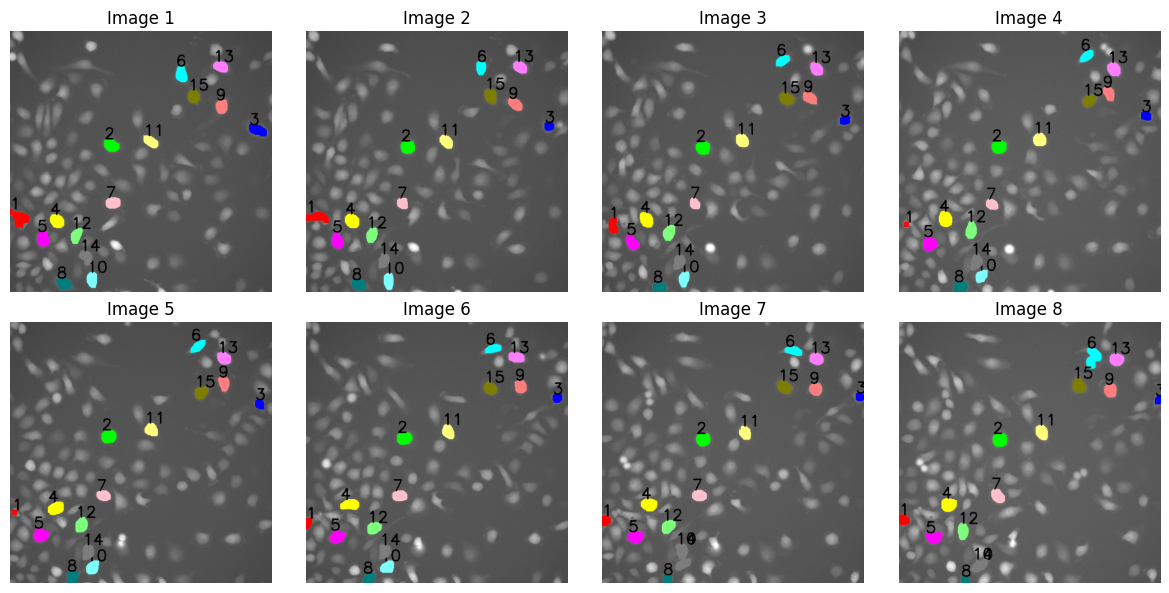

In [54]:
display_eight(colored_results[:8], start=0)